In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/') # Change as needed...
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
INFO = True
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# initiate iop dict
# iops, cols, row = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)

# dictionary for Case 2 turbid water 
with open('/nobackup/jakravit/data/iops_test.p','rb') as fp:
    iops_case2 = pickle.load(fp)

# dictionary for blue Case 1 water
with open('/nobackup/jakravit/data/case1_runlist.p','rb') as fp:
    case1 = pickle.load(fp)
runID1 = '0.563_0.015_0.033_0.032_FShk4FqxnG'
iops_case1 = case1[runID1]    

if INFO:
    print ('CASE 1 INFO:')
    print ('Chla: {} ug/L'.format(iops_case1['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case1['Min']['tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case1['CDOM']['a_tot'][80]))
    print ('\nCASE 2 INFO:')
    print ('Chla: {} ug/L'.format(iops_case2['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case2['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case2['CDOM']['ag440']))
    # print ('Max Depth: {} m'.format(iops_case1['Depth']['Dmax']))
    # print ('Water radius: {} km'.format(iops_case1['Adjacency']['water_radius']))
    # print ('Dist from shore: {} km'.format(iops_case1['Adjacency']['dist']))

CASE 1 INFO:
Chla: 0.563 ug/L
Minl: 0.014625739628414677 g/L
ag440: 0.08964525121529826 m^-1

CASE 2 INFO:
Chla: 12.062 ug/L
Minl: 3.1160428571428573 g/L
ag440: 1.16 m^-1


 Datasets:
  [0] T_oc (float32 in [280, 280]), axes=('z_oc',)
  [1] phase_oc (float64 in [0, 9.2]), axes=('iphase', 'stk', 'theta_oc')
  [2] iphase_oc (int32 in [0, 15]), axes=('wavelength', 'z_oc')
  [3] OD_w (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [4] OD_p_oc (float64 in [-0.134, 0]), axes=('wavelength', 'z_oc')
  [5] OD_y (float64 in [-1.03, 0]), axes=('wavelength', 'z_oc')
  [6] OD_oc (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [7] OD_sca_oc (float64 in [-0.0822, 0]), axes=('wavelength', 'z_oc')
  [8] OD_abs_oc (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [9] pine_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  [10] pmol_oc (float32 in [0.0348, 1]), axes=('wavelength', 'z_oc')
  [11] ssa_oc (float64 in [0.00123, 1]), axes=('wavelength', 'z_oc')
  [12] ssa_p_oc (float32 in [0.33, 1]), axes=('wavelength', 'z_oc')
  [13] ssa_w (float64 in [4.3e-05, 1]), axes=('wavelength', 'z_oc')
  [14] FQY1_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')

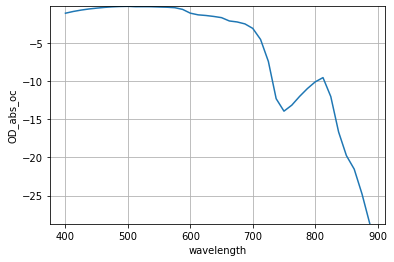

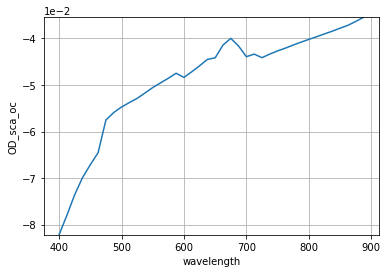

In [9]:
from smartg_int_library import *

# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops_case1)
ap2,ac2,bp2,vsf2,angles = mix(iops_case2)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,200,5)
wav      = WAV[wavrange]
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,50)
wav_vsf      = WAV[wavrange_vsf]
# vertical grids
Z    = np.array([0, -1., -2.5, -5.])
Z2   = np.array([0., -3., -6, -10.])
zeros=np.zeros_like(wav)

#IOP's profiles
# case 1 lists
vsf_list1=[vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:] ]
bp_list1 = [zeros, bp1[wavrange], bp1[wavrange], bp1[wavrange]]
ap_list1 = [zeros, ap1[wavrange], ap1[wavrange], ap1[wavrange]]
ac_list1 = [zeros, ac1[wavrange], ac1[wavrange], ac1[wavrange]]
#aw_list = [zeros, ww['aw'], ww['aw'], ww['aw']] 
#bw_list = [zeros, ww['bw'], ww['bw'], ww['bw']] 
aw_list = None # use SMART-G default pure water absorption
bw_list = None # use SMART-G default pure water scattering

# case 2 lists
vsf_list2=[vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:] ]
bp_list2 = [zeros, bp2[wavrange], bp2[wavrange], bp2[wavrange]]
ap_list2 = [zeros, ap2[wavrange], ap2[wavrange], ap2[wavrange]]
ac_list2 = [zeros, ac2[wavrange], ac2[wavrange], ac2[wavrange]]

# Albedos speclib library inputs
Type = ['Sand', 'Forest']
ALB  = [Albedo_speclib('/nobackup/jakravit/data/albedos/rock.sedimentary.sandstone.fine.all.sandstone_7.jhu.becknic.spectrum.txt'),
        Albedo_speclib('/nobackup/jakravit/data/albedos/vegetation.tree.betula.lenta.vswir.bele-1-55.ucsb.asd.spectrum.txt')]
ALB0 = Albedo_cst(0.05)


# dirspec = '/rfs/data/speclib2.0/data/'
# Type = ['Sand', 'Forest']
# ALB  = [Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt'),
#         Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt')]
# # Type    = ['Forest', 'Bare soil', 'Grass', 'Snow', 'Sand']
# # ALB     = [Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.soil.alfisol.paleustalf.coarse.87P473.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.vegetation.grass.green.solid.gras.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.water.snow.granular.82um.medium.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt')]

# water MLUT building
# VSF truncation at 25 deg

# Case 1 water (varying bottom albedos)
waterC1Sand5m   = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25., ALB=ALB[0])
waterC1Sand10m  = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z2, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB[0])
waterC1Lamb10m   = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z2, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB0)

# check
waterC1Sand5m.describe()
waterC1Sand5m['OD_abs_oc'].sub()[:,-1].plot()
figure()
waterC1Sand5m['OD_sca_oc'].sub()[:,-1].plot()

In [46]:
# Ocean surface
surf1 = RoughSurface(WAVE_SHADOW=True, WIND=2.)
surf2 = RoughSurface(WAVE_SHADOW=True, WIND=18.)

# Land environment
D1       = 1.0e6 #(km) # simulates straight coastline
D2       = 4           # simulates small water body

# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB

# env1 : oceanic straight coastline simulation
env1     = Environment(ENV=1, 
                      ENV_SIZE= D1 ,       # radius of the circle with ocean surface condition
                      X0= -D1,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=ALB[1] # Lambertian grey albedo of the land zone (forest)
                     )
# env2 : small water body simulation
env2     = Environment(ENV=1, 
                      ENV_SIZE= D2 ,       # radius of the circle with ocean surface condition
                      X0= -D2,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=ALB[1] # Lambertian grey albedo of the land zone (forest)
                     )

# Distance to coast/shore (adjacency test)
dist1 = .5
dist2 = 10

# Geometries 
HTOA   = 120.
VZA    = 30.
VAA    = 90.
SZA    = 60.
SAA    = 0.
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))

# Backward Local Estimate -> Solar geometries
leb = {'th_deg':np.array([SZA]), 'phi_deg':np.array([SAA])}
# Forward Local Estimate -> observation geometries
lef = {'th_deg':np.array([VZA]), 'phi_deg':np.array([VAA])}

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's
atm = AtmAFGL('afglt', comp=[AeroOPAC('continental_average', 0.2, 550)], pfwav=wav_vsf).calc(wav)

# alis
alis = True
alis_options = {'nlow':-1}
SMBa = Smartg(device=0, back=True, alt_pp=True, alis=alis) # backward
SMFa = Smartg(device=0, back=False, alt_pp=True, alis=alis) # forward

####################################################################################################################################################
# Simulation 1: Forward vs Backward RTM

- This section simulates the difference in TOA and BOA modeled reflectance for forward and backward running of smartg.

#### INFO: 
    - Case 1 oligotrophic water. 
    - lambertian 0.5 albedo @ 10m depth
    - straight coastline, target .5km from shore (forest land albedo)
    - Low sunglint (low wind)

In [47]:
%%time

# SENSORS
# Observer at TOA
sensor_TOA = Sensor(POSX=-dist1+DeltaX, POSY=DeltaY, POSZ=HTOA, THDEG=180-VZA, PHDEG=VAA, LOC='ATMOS', FOV=0., TYPE=0)
# Observer at BOA (0+)
sensor_BOA = Sensor(POSX = -dist1, THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')
# Observer at Sun
sensor_sun = Sensor(POSZ=HTOA, THDEG=180-SZA, PHDEG=SAA, TYPE=0, LOC='ATMOS')

# case1 water w/ alis and adjacency : Backward, sensor at TOA
mBc1env  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=env1, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis and no adjacency : Backward, sensor at TOA
mBc1  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=None, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis and no adjacency : Forward, sensor at SUN
mFc1  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

#----------------------------

# case1 water w/ alis and adjacency: Backward, sensor at BOA
mBOAc1env  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=env1, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis and no adjacency: Backward, sensor at BOA
mBOAc1  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 2.93 s, sys: 2.13 s, total: 5.06 s
Wall time: 5.44 s


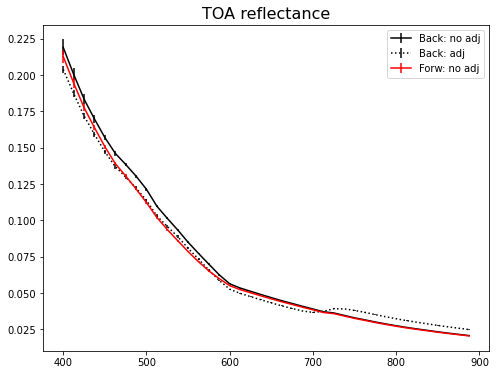

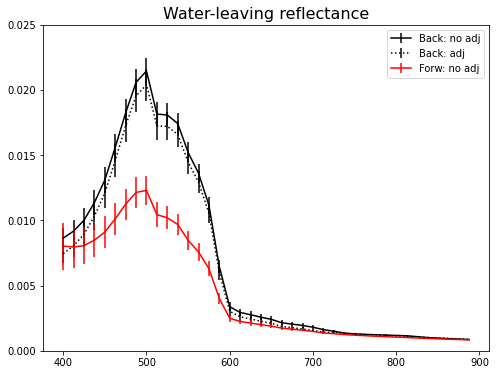

In [48]:
## plot simulation 1 results for TOA ##
lut1 = mBc1 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBc1env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBc1env ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1 ['I_up (TOA)'].sub()[:,0,0]
err3 = mFc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
figure(figsize=(8,6))
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: no adj') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: adj') # Backward adjacency
errorbar(wav, lut3.data, yerr=err3.data, fmt='r-', label='Forw: no adj') # Forward  no adjacency
title('TOA reflectance', fontsize=16)
legend()
         
## plot simulation 1 results for BOA ##
#(forward sim so no adjacency)
figure(figsize=(8,6))
lut1 = mBOAc1 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOAc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOAc1env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOAc1env ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1 ['I_up (0+)'].sub()[:,0,0]
err3 = mFc1 ['I_stdev_up (0+)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: no adj') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: adj') # Backward adjacency
errorbar(wav, lut3.data, yerr=err3.data, fmt='r-', label='Forw: no adj') # Forward  no adjacency
ylim(0,0.025)
title('Water-leaving reflectance', fontsize=16)
legend()

## Simulation 1 Result Comments/Questions

- Some deviation between reflectance results of forward and backward runs (Black vs Red lines)
- Small deviation at TOA, large deviation at BOA
- Accuracy of forward vs backward simulated reflectances? 
    - Which one to use? 
    - Comparison with Hydrolight?
- If adjacency is included at TOA for a given IOP case, will I need to run two different smartg simulations to retrieve both BOA (in forward mode) and TOA (in backward mode) 
    - If no adjacency included, I can just do one simulation in forward mode and retrieve BOA and TOA?

####################################################################################################################################################
# Simulation 2: surface glint effects

- This section simulates difference in glint effects at TOA and BOA modeled reflectance for variations in wind speed.

#### INFO: 
    - Case 1 oligotrophic water
    - lambertian 0.5 albedo at 10m depth
    - no adjacency
    - Forward and backward mode

In [49]:
# case1 water w/ alis and no adjacency, low wind : Forward, sensor at SUN
mFc1s1  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

# case1 water w/ alis and no adjacency, high wind : Forward, sensor at SUN
mFc1s2  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf2, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

# case1 water w/ alis and no adjacency, high wind : Backward, sensor at BOA
mBc1s1  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis and no adjacency, high wind : Backward, sensor at BOA
mBc1s2  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf2, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

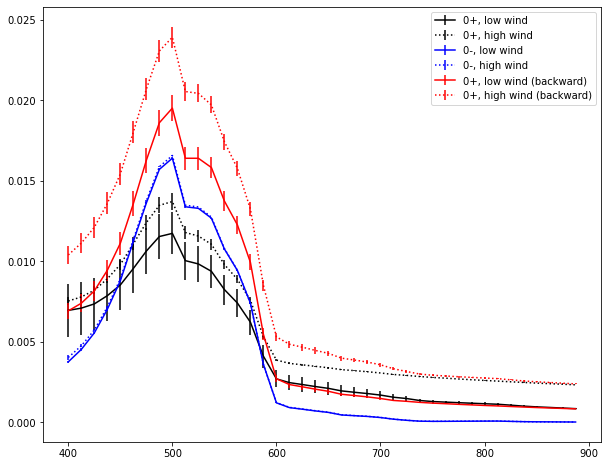

In [50]:
lut1 = mFc1s1 ['I_up (0+)'].sub()[:,0,0]
err1 = mFc1s1 ['I_stdev_up (0+)'].sub()[:,0,0]
lut2 = mFc1s2 ['I_up (0+)'].sub()[:,0,0]
err2 = mFc1s2 ['I_stdev_up (0+)'].sub()[:,0,0]

lut3 = mFc1s1 ['I_up (0-)'].sub()[:,0,0]
err3 = mFc1s1 ['I_stdev_up (0-)'].sub()[:,0,0]
lut4 = mFc1s2 ['I_up (0-)'].sub()[:,0,0]
err4 = mFc1s2 ['I_stdev_up (0-)'].sub()[:,0,0]

lut5 = mBc1s1 ['I_up (TOA)'].sub()[:,0,0]
err5 = mBc1s1 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut6 = mBc1s2 ['I_up (TOA)'].sub()[:,0,0]
err6 = mBc1s2 ['I_stdev_up (TOA)'].sub()[:,0,0]

figure(figsize=(10,8))
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='0+, low wind') 
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='0+, high wind')
errorbar(wav, lut3.data, yerr=err3.data, fmt='b-', label='0-, low wind')
errorbar(wav, lut4.data, yerr=err4.data, fmt='b:', label='0-, high wind')
errorbar(wav, lut5.data, yerr=err5.data, fmt='r-', label='0+, low wind (backward)')
errorbar(wav, lut6.data, yerr=err6.data, fmt='r:', label='0+, high wind (backward)')
legend()


## Simulation 2 Result Comments/Questions

- Again, note difference in magnitude with forward vs backward modes
- Above surface Reflectance in forward mode (black) - pretty small change in glint effects, does this seem correct for a difference in wind between 2 and 18?
- Below surface reflectance in forward mode (blue) - no difference between two wind speeds which is expected. 
- Slightly different results each time run the same simulation? Because of monte carlo technique?

####################################################################################################################################################
# Simulation 3: Bottom albedo effects

- This section simulates differences in resulting reflectance at BOA and TOA given variations in bottom albedo depth.

#### INFO: 
    - Case 1 oligotrophic water
    - Bottom albedos: 
        - Lambertian .5 albedo @ 5m, 10m depth
        - Sand albedo @ 5m, 10m depth
    - no adjacency
    - Forward and backward mode

In [51]:
# case1 water w/ alis, no adjacency, sand albedo 5m, low wind : Backward, sensor at TOA
mBc1s5m  = SMBa.run(wl=wav, water=waterC1Sand5m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=None, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis, no adjacency, sand albedo 10m, low wind : Backward, sensor at TOA
mBc1s10m  = SMBa.run(wl=wav, water=waterC1Sand10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=None, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis, no adjacency, sand albedo 5m, low wind : Forward, sensor at SUN
mFc1s5m  = SMFa.run(wl=wav, water=waterC1Sand5m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

# case1 water w/ alis, no adjacency, sand albedo 10m, low wind : Forward, sensor at SUN
mFc1s10m  = SMFa.run(wl=wav, water=waterC1Sand10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

# case1 water w/ alis, no adjacency, lambertion 0.5 at 10m, low wind : Forward, sensor at SUN
mFc1l10m  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

#----------------------------

# case1 water w/ alis and adjacency: Backward, sensor at BOA
mBOAc1s5m  = SMBa.run(wl=wav, water=waterC1Sand5m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis and no adjacency: Backward, sensor at BOA
mBOAc1s10m  = SMBa.run(wl=wav, water=waterC1Sand10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

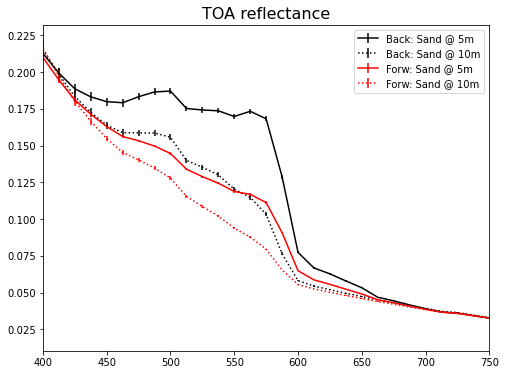

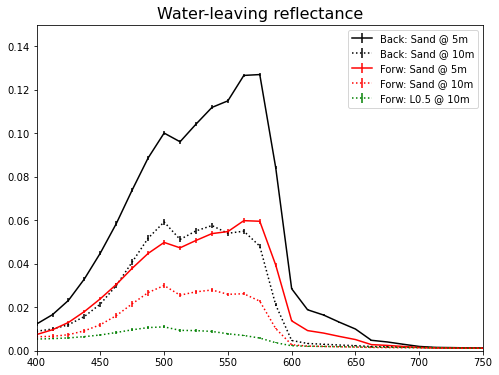

In [52]:
## plot simulation 3 results for TOA ##
lut1 = mBc1s5m ['I_up (TOA)'].sub()[:,0,0]
err1 = mBc1s5m ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBc1s10m ['I_up (TOA)'].sub()[:,0,0]
err2 = mBc1s10m ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1s5m ['I_up (TOA)'].sub()[:,0,0]
err3 = mFc1s5m ['I_stdev_up (TOA)'].sub()[:,0,0]
lut4 = mFc1s10m ['I_up (TOA)'].sub()[:,0,0]
err4 = mFc1s10m ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
figure(figsize=(8,6))
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: Sand @ 5m') 
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: Sand @ 10m') 
errorbar(wav, lut3.data, yerr=err3.data, fmt='r-', label='Forw: Sand @ 5m') 
errorbar(wav, lut4.data, yerr=err4.data, fmt='r:', label='Forw: Sand @ 10m')
title('TOA reflectance', fontsize=16)
xlim(400,750)
legend()

## plot simulation 3 results for BOA ##
#(forward sim so no adjacency)
figure(figsize=(8,6))
lut1 = mBOAc1s5m ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOAc1s5m ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOAc1s10m ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOAc1s10m ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1s5m ['I_up (0+)'].sub()[:,0,0]
err3 = mFc1s5m ['I_stdev_up (0+)'].sub()[:,0,0]
lut4 = mFc1s10m ['I_up (0+)'].sub()[:,0,0]
err4 = mFc1s10m ['I_stdev_up (0+)'].sub()[:,0,0]
lut5 = mFc1l10m ['I_up (0+)'].sub()[:,0,0]
err5 = mFc1l10m ['I_stdev_up (0+)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: Sand @ 5m')
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: Sand @ 10m') 
errorbar(wav, lut3.data, yerr=err3.data, fmt='r-', label='Forw: Sand @ 5m')
errorbar(wav, lut4.data, yerr=err4.data, fmt='r:', label='Forw: Sand @ 10m')
errorbar(wav, lut5.data, yerr=err5.data, fmt='g:', label='Forw: L0.5 @ 10m') # lambertian 0.5
ylim(0,0.15)
xlim(400,750)
title('Water-leaving reflectance', fontsize=16)
legend()

## Simulation 3 Result Comments/Questions

- seems pretty self explanatory and reasonable: Sand at both 5m and 10m contributes considerable signal, obviously more at shallower depth. 
- usual difference between forward and backward modes

####################################################################################################################################################
# Simulation 4: Adjacency effects

- This section simulates differences in resulting reflectance at BOA and TOA given variations in water body size and distance to shore.

#### INFO: 
    - Case 1 oligotrophic water
    - Bottom albedos: Lambertian .5 @ 10m depth
    - Adjacency sims:
        - straight coast, 0.5km distance
        - straight coast, 10km distance
        - 4km wide small water body, 0.5km distance
    - Forward and backward mode

In [53]:

# case1 water w/ alis, straight coast, 0.5km dist, lamb .5 bottom alb, low wind : Backward, sensor at TOA
sensor_TOA = Sensor(POSX=-dist1+DeltaX, POSY=DeltaY, POSZ=HTOA, THDEG=180-VZA, PHDEG=VAA, LOC='ATMOS', FOV=0., TYPE=0)
mBc1c5  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=env1, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis, straight coast, 10km dist, lamb .5 bottom alb, low wind : Backward, sensor at TOA
sensor_TOA = Sensor(POSX=-dist2+DeltaX, POSY=DeltaY, POSZ=HTOA, THDEG=180-VZA, PHDEG=VAA, LOC='ATMOS', FOV=0., TYPE=0)
mBc1c10  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, env=env1, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis, small water body, 0.5km dist, lamb .5 bottom alb, low wind : Backward, sensor at TOA
sensor_TOA = Sensor(POSX=-dist1+DeltaX, POSY=DeltaY, POSZ=HTOA, THDEG=180-VZA, PHDEG=VAA, LOC='ATMOS', FOV=0., TYPE=0)
mFc1b5  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True, env=env2,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis, no env, no dist, lamb .5 bottom alb, low wind : Forward, sensor at SUN
mFc1  = SMFa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

# #----------------------------

# case1 water w/ alis, no env, 0.5km dist, lamb .5 bottom alb, low wind : Backward, sensor at BOA
sensor_BOA = Sensor(POSX = -dist1, THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')
mBOAc1c5  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                      sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis, no env, 10km dist, lamb .5 bottom alb, low wind : Backward, sensor at BOA
sensor_BOA = Sensor(POSX = -dist2, THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')
mBOAc1c10  = SMBa.run(wl=wav, water=waterC1Lamb10m, atm=atm, surf=surf1, NBPHOTONS=1e6, stdev=True,
                      sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

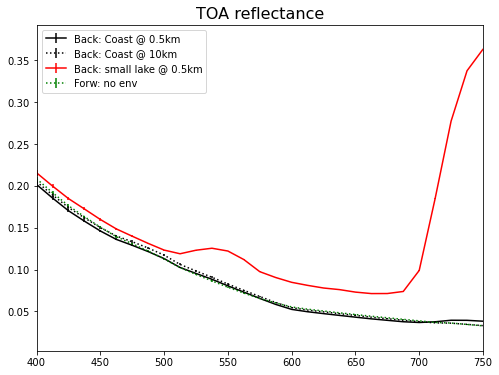

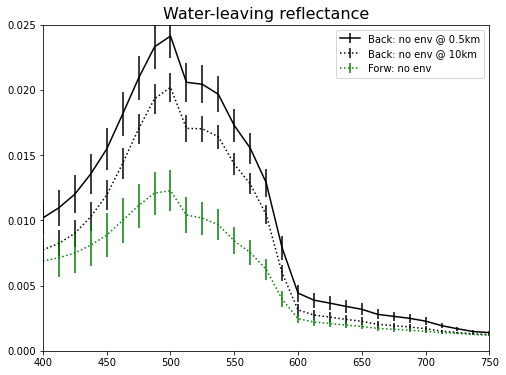

In [54]:
## plot simulation 4 results for TOA ##
lut1 = mBc1c5 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBc1c5 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBc1c10 ['I_up (TOA)'].sub()[:,0,0]
err2 = mBc1c10 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1b5 ['I_up (TOA)'].sub()[:,0,0]
err3 = mFc1b5 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut4 = mFc1 ['I_up (TOA)'].sub()[:,0,0]
err4 = mFc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
figure(figsize=(8,6))
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: Coast @ 0.5km') 
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: Coast @ 10km') 
errorbar(wav, lut3.data, yerr=err3.data, fmt='r-', label='Back: small lake @ 0.5km') 
errorbar(wav, lut4.data, yerr=err4.data, fmt='g:', label='Forw: no env')
title('TOA reflectance', fontsize=16)
xlim(400,750)
legend()


## plot simulation 4 results for BOA ##
figure(figsize=(8,6))
lut1 = mBOAc1c5 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOAc1c5 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOAc1c10 ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOAc1c10 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc1 ['I_up (0+)'].sub()[:,0,0]
err3 = mFc1 ['I_stdev_up (0+)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-', label='Back: no env @ 0.5km')
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:', label='Back: no env @ 10km') 
errorbar(wav, lut3.data, yerr=err3.data, fmt='g:', label='Forw: no env')
ylim(0,0.025)
xlim(400,750)
title('Water-leaving reflectance', fontsize=16)
legend()

## Simulation 4 Result Comments/Questions

- I am curious if the dist parameter is having an effect when running in backward mode even if the env dictionary is not provided for water-leaving reflectanc?